In [1]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 60

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6

In [2]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\lai\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        # df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

         high       low     close    change      50ma     100ma     200ma  \
199  0.000000  0.000020  0.357085 -0.000150  0.351429  0.351070  0.346428   
200  0.000010  0.000050  0.356606 -0.000060  0.351433  0.351063  0.346426   
201  0.000065  0.000025  0.356893  0.000035  0.351445  0.351060  0.346424   
202  0.000000  0.000005  0.357133  0.000015  0.351502  0.351082  0.346433   
203  0.000030  0.000000  0.358138  0.000095  0.351587  0.351141  0.346448   

     y_result  
199         0  
200         0  
201         0  
202         0  
203         0  


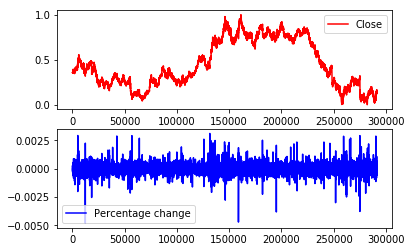

In [6]:
plot_stock(df)

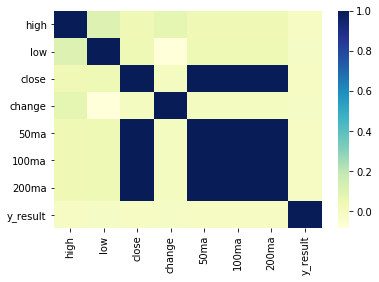

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7
Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 7) (174613,) (70626, 120, 7) (70626,)
7


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == 50):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/60 Iteration: 5 Train loss: 1.057885 Train acc: 0.503418
Epoch: 0/60 Iteration: 10 Train loss: 1.091833 Train acc: 0.399902
Epoch: 0/60 Iteration: 15 Train loss: 1.140871 Train acc: 0.348633
Epoch: 0/60 Iteration: 20 Train loss: 1.093880 Train acc: 0.410156
Epoch: 0/60 Iteration: 25 Train loss: 1.144037 Train acc: 0.312988
Epoch: 0/60 Iteration: 30 Train loss: 1.060724 Train acc: 0.467773
Epoch: 0/60 Iteration: 35 Train loss: 1.000071 Train acc: 0.579102
Epoch: 0/60 Iteration: 40 Train loss: 1.000040 Train acc: 0.584961
Epoch: 0/60 Iteration: 45 Train loss: 1.119756 Train acc: 0.278320
Epoch: 0/60 Iteration: 50 Train loss: 0.981162 Train acc: 0.631836
Epoch: 0/60 Iteration: 55 Train loss: 1.062606 Train acc: 0.494629
Epoch: 0/60 Iteration: 60 Train loss: 1.114926 Train acc: 0.284668
Epoch: 0/60 Iteration: 65 Train loss: 1.095968 Train acc: 0.359863
Epoch: 0/60 Iteration: 70 Train loss: 1.097999 Train acc: 0.35

Epoch: 7/60 Iteration: 605 Train loss: 1.094050 Train acc: 0.399902
Epoch: 7/60 Iteration: 610 Train loss: 1.137021 Train acc: 0.348633
Epoch: 7/60 Iteration: 615 Train loss: 1.092688 Train acc: 0.410156
Epoch: 7/60 Iteration: 620 Train loss: 1.145277 Train acc: 0.312988
Epoch: 7/60 Iteration: 625 Train loss: 1.060887 Train acc: 0.467773
Epoch: 7/60 Iteration: 630 Train loss: 1.001494 Train acc: 0.579102
Epoch: 7/60 Iteration: 635 Train loss: 0.999173 Train acc: 0.584961
Epoch: 7/60 Iteration: 640 Train loss: 1.129023 Train acc: 0.278320
Epoch: 7/60 Iteration: 645 Train loss: 0.977760 Train acc: 0.631836
Epoch: 7/60 Iteration: 650 Train loss: 1.058310 Train acc: 0.494629
Epoch: 7/60 Iteration: 655 Train loss: 1.112266 Train acc: 0.251953
Epoch: 7/60 Iteration: 660 Train loss: 1.091405 Train acc: 0.427734
Epoch: 7/60 Iteration: 665 Train loss: 1.091603 Train acc: 0.435059
Epoch: 7/60 Iteration: 670 Train loss: 1.017500 Train acc: 0.431641
Epoch: 7/60 Iteration: 675 Train loss: 1.189229 

Epoch: 14/60 Iteration: 1200 Train loss: 1.094361 Train acc: 0.399902
Epoch: 14/60 Iteration: 1205 Train loss: 1.138321 Train acc: 0.348633
Epoch: 14/60 Iteration: 1210 Train loss: 1.093001 Train acc: 0.410156
Epoch: 14/60 Iteration: 1215 Train loss: 1.142846 Train acc: 0.312988
Epoch: 14/60 Iteration: 1220 Train loss: 1.060174 Train acc: 0.467773
Epoch: 14/60 Iteration: 1225 Train loss: 1.000825 Train acc: 0.579102
Epoch: 14/60 Iteration: 1230 Train loss: 0.998806 Train acc: 0.584961
Epoch: 14/60 Iteration: 1235 Train loss: 1.127099 Train acc: 0.278320
Epoch: 14/60 Iteration: 1240 Train loss: 0.977700 Train acc: 0.631836
Epoch: 14/60 Iteration: 1245 Train loss: 1.059029 Train acc: 0.494629
Epoch: 14/60 Iteration: 1250 Train loss: 1.113914 Train acc: 0.247559
Epoch: 14/60 Iteration: 1255 Train loss: 1.092988 Train acc: 0.423340
Epoch: 14/60 Iteration: 1260 Train loss: 1.092141 Train acc: 0.437988
Epoch: 14/60 Iteration: 1265 Train loss: 1.018393 Train acc: 0.439453
Epoch: 14/60 Iterati

Epoch: 21/60 Iteration: 1790 Train loss: 1.051998 Train acc: 0.503418
Epoch: 21/60 Iteration: 1795 Train loss: 1.093904 Train acc: 0.399902
Epoch: 21/60 Iteration: 1800 Train loss: 1.134734 Train acc: 0.348633
Epoch: 21/60 Iteration: 1805 Train loss: 1.090665 Train acc: 0.410156
Epoch: 21/60 Iteration: 1810 Train loss: 1.143976 Train acc: 0.312988
Epoch: 21/60 Iteration: 1815 Train loss: 1.060443 Train acc: 0.467773
Epoch: 21/60 Iteration: 1820 Train loss: 1.000600 Train acc: 0.579102
Epoch: 21/60 Iteration: 1825 Train loss: 0.998169 Train acc: 0.584961
Epoch: 21/60 Iteration: 1830 Train loss: 1.132297 Train acc: 0.278320
Epoch: 21/60 Iteration: 1835 Train loss: 0.977135 Train acc: 0.631836
Epoch: 21/60 Iteration: 1840 Train loss: 1.056442 Train acc: 0.494629
Epoch: 21/60 Iteration: 1845 Train loss: 1.105582 Train acc: 0.268555
Epoch: 21/60 Iteration: 1850 Train loss: 1.093170 Train acc: 0.426270
Epoch: 21/60 Iteration: 1855 Train loss: 1.093455 Train acc: 0.440430
Epoch: 21/60 Iterati

Epoch: 27/60 Iteration: 2380 Train loss: 1.188439 Train acc: 0.231445
Epoch: 28/60 Iteration: 2385 Train loss: 1.052281 Train acc: 0.503418
Epoch: 28/60 Iteration: 2390 Train loss: 1.093405 Train acc: 0.399902
Epoch: 28/60 Iteration: 2395 Train loss: 1.134854 Train acc: 0.348633
Epoch: 28/60 Iteration: 2400 Train loss: 1.091146 Train acc: 0.410156
Epoch: 28/60 Iteration: 2405 Train loss: 1.145006 Train acc: 0.312988
Epoch: 28/60 Iteration: 2410 Train loss: 1.059864 Train acc: 0.467773
Epoch: 28/60 Iteration: 2415 Train loss: 0.998981 Train acc: 0.579102
Epoch: 28/60 Iteration: 2420 Train loss: 0.998005 Train acc: 0.584961
Epoch: 28/60 Iteration: 2425 Train loss: 1.133044 Train acc: 0.278320
Epoch: 28/60 Iteration: 2430 Train loss: 0.977391 Train acc: 0.631836
Epoch: 28/60 Iteration: 2435 Train loss: 1.056115 Train acc: 0.494629
Epoch: 28/60 Iteration: 2440 Train loss: 1.104954 Train acc: 0.288574
Epoch: 28/60 Iteration: 2445 Train loss: 1.096408 Train acc: 0.395020
Epoch: 28/60 Iterati

Epoch: 34/60 Iteration: 2970 Train loss: 1.179882 Train acc: 0.338867
Epoch: 34/60 Iteration: 2975 Train loss: 1.193766 Train acc: 0.232422
Epoch: 35/60 Iteration: 2980 Train loss: 1.052802 Train acc: 0.503418
Epoch: 35/60 Iteration: 2985 Train loss: 1.093556 Train acc: 0.399902
Epoch: 35/60 Iteration: 2990 Train loss: 1.135094 Train acc: 0.348633
Epoch: 35/60 Iteration: 2995 Train loss: 1.090297 Train acc: 0.410156
Epoch: 35/60 Iteration: 3000 Train loss: 1.145657 Train acc: 0.312988
Epoch: 35/60 Iteration: 3005 Train loss: 1.060267 Train acc: 0.467773
Epoch: 35/60 Iteration: 3010 Train loss: 0.998171 Train acc: 0.579102
Epoch: 35/60 Iteration: 3015 Train loss: 0.998761 Train acc: 0.584961
Epoch: 35/60 Iteration: 3020 Train loss: 1.134248 Train acc: 0.278320
Epoch: 35/60 Iteration: 3025 Train loss: 0.978136 Train acc: 0.631836
Epoch: 35/60 Iteration: 3030 Train loss: 1.055289 Train acc: 0.494629
Epoch: 35/60 Iteration: 3035 Train loss: 1.104876 Train acc: 0.283203
Epoch: 35/60 Iterati

Epoch: 41/60 Iteration: 3560 Train loss: 1.011658 Train acc: 0.450195
Epoch: 41/60 Iteration: 3565 Train loss: 1.190122 Train acc: 0.354492
Epoch: 41/60 Iteration: 3570 Train loss: 1.204869 Train acc: 0.230957
Epoch: 42/60 Iteration: 3575 Train loss: 1.058280 Train acc: 0.503418
Epoch: 42/60 Iteration: 3580 Train loss: 1.094898 Train acc: 0.399902
Epoch: 42/60 Iteration: 3585 Train loss: 1.139015 Train acc: 0.348633
Epoch: 42/60 Iteration: 3590 Train loss: 1.093248 Train acc: 0.410156
Epoch: 42/60 Iteration: 3595 Train loss: 1.143264 Train acc: 0.312988
Epoch: 42/60 Iteration: 3600 Train loss: 1.061516 Train acc: 0.467773
Epoch: 42/60 Iteration: 3605 Train loss: 0.999264 Train acc: 0.579102
Epoch: 42/60 Iteration: 3610 Train loss: 0.998103 Train acc: 0.584961
Epoch: 42/60 Iteration: 3615 Train loss: 1.129819 Train acc: 0.278320
Epoch: 42/60 Iteration: 3620 Train loss: 0.980180 Train acc: 0.631836
Epoch: 42/60 Iteration: 3625 Train loss: 1.057778 Train acc: 0.494629
Epoch: 42/60 Iterati

Epoch: 48/60 Iteration: 4150 Train loss: 1.093426 Train acc: 0.456543
Epoch: 48/60 Iteration: 4155 Train loss: 1.010788 Train acc: 0.444824
Epoch: 48/60 Iteration: 4160 Train loss: 1.187806 Train acc: 0.345703
Epoch: 48/60 Iteration: 4165 Train loss: 1.206707 Train acc: 0.231445
Epoch: 49/60 Iteration: 4170 Train loss: 1.057726 Train acc: 0.503418
Epoch: 49/60 Iteration: 4175 Train loss: 1.094339 Train acc: 0.399902
Epoch: 49/60 Iteration: 4180 Train loss: 1.136040 Train acc: 0.348633
Epoch: 49/60 Iteration: 4185 Train loss: 1.092503 Train acc: 0.410156
Epoch: 49/60 Iteration: 4190 Train loss: 1.146585 Train acc: 0.312988
Epoch: 49/60 Iteration: 4195 Train loss: 1.058676 Train acc: 0.467773
Epoch: 49/60 Iteration: 4200 Train loss: 0.998918 Train acc: 0.579102
Epoch: 49/60 Iteration: 4205 Train loss: 0.997263 Train acc: 0.584961
Epoch: 49/60 Iteration: 4210 Train loss: 1.131277 Train acc: 0.278320
Epoch: 49/60 Iteration: 4215 Train loss: 0.978503 Train acc: 0.631836
Epoch: 49/60 Iterati

Epoch: 55/60 Iteration: 4740 Train loss: 1.082379 Train acc: 0.442871
Epoch: 55/60 Iteration: 4745 Train loss: 1.090236 Train acc: 0.473633
Epoch: 55/60 Iteration: 4750 Train loss: 1.021347 Train acc: 0.418945
Epoch: 55/60 Iteration: 4755 Train loss: 1.177119 Train acc: 0.334473
Epoch: 55/60 Iteration: 4760 Train loss: 1.181907 Train acc: 0.231445
Epoch: 56/60 Iteration: 4765 Train loss: 1.049001 Train acc: 0.503418
Epoch: 56/60 Iteration: 4770 Train loss: 1.094727 Train acc: 0.399902
Epoch: 56/60 Iteration: 4775 Train loss: 1.135376 Train acc: 0.348633
Epoch: 56/60 Iteration: 4780 Train loss: 1.090687 Train acc: 0.410156
Epoch: 56/60 Iteration: 4785 Train loss: 1.145243 Train acc: 0.312988
Epoch: 56/60 Iteration: 4790 Train loss: 1.061693 Train acc: 0.467773
Epoch: 56/60 Iteration: 4795 Train loss: 0.999744 Train acc: 0.579102
Epoch: 56/60 Iteration: 4800 Train loss: 0.998899 Train acc: 0.584961
Epoch: 56/60 Iteration: 4805 Train loss: 1.133508 Train acc: 0.278320
Epoch: 56/60 Iterati

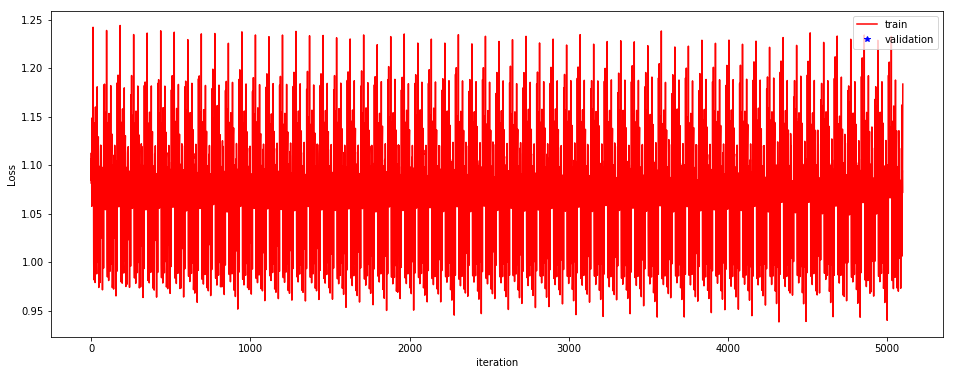

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == 50], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

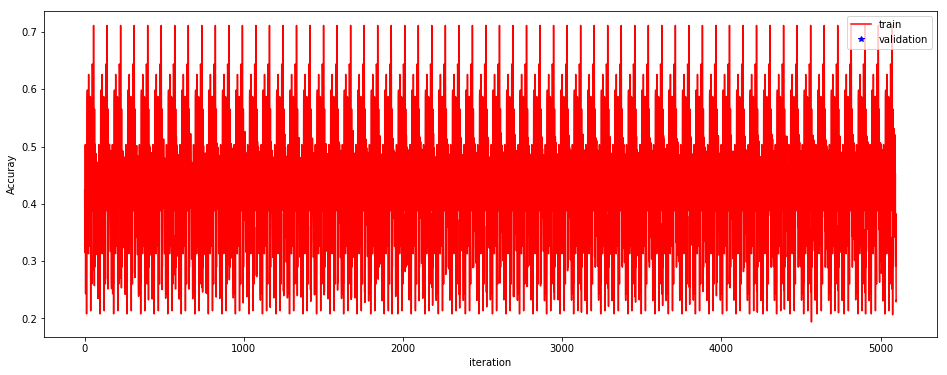

In [17]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == 50], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [18]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):        
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
0.478516
0.659668
0.386719
0.580078
0.434082
0.516113
0.537109
0.554199
0.516602
0.393555
0.513672
0.544922
0.507813
0.47998
0.382324
0.337891
0.0888672
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Test accuracy: 0.232709


In [19]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [20]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [21]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined